In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='fastnodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'fastnodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# GW convergence analysis for monolayer MoS$_2$

We perform a convergence study for the GW runlevel

In particular we make usage of the _slab z_ option to implement the cutoff of the Coulomb and effective potentials in the $z$ direction.

We use this runlevel to study the convergence of some computational parameters that is relevant
also for the BSE analysis.

## HF Analysis for RIM and Coulomb cutoff parameters

As a first step we use this runlevel to study the convergence properties of the RIM and Coulomb cutoff procedures.

This analysis is performed with a 18x18x1 k-points sampling.

In [4]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

save_dir = Tools.make_p2y(source_dir)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We compute the HF gap at the $\Gamma$ and $K$ point and use these values to study the convergence
of the RIM and cutoff procedures.

Here we define the parameters common to all the runs.

In [5]:
start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37

EXXRLvcs = 40. # Ha # reference value, the convergence of this parameter will be performed later
EXXRLVcs_units = 'Ha'

In [7]:
inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp

{'args': 'yambo -r -x -V all',
 'folder': 'GW_analysis/kpoints_18-nbnds_250',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [26.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [262858.0, 'Kb'],
  'FFTGvecs': [18201.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [0.0, ''],
  'RandGvec': [1.0, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [40.0, 'Ha'],
  'VXCRLvcs': [40.0, 'Ha'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 26, 27], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the RandGvec parameter

In [8]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = [15,30,50,100,150,200] # use the RIM for the first RandGvec G-components of the coulomb potential 

inp['variables']['RandQpts'] = [RandQpts,'']

# append runs for the Gamma point
for randgvec in RandGvec:
    idd = 'hf-G-randqpts_%s-randgvec_%s'%(RandQpts,randgvec)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units='RL',RandGvec=randgvec)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randgvec in RandGvec:
    idd = 'hf-K-randqpts_%s-randgvec_%s'%(RandQpts,randgvec)
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units='RL',RandGvec=randgvec)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [13]:
#study.runs[0]

In [14]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofhf-G-randqpts_1000000-randgvec_30Skip the run of 
 hf-G-randqpts_1000000-randgvec_50Skip the run ofhf-G-randqpts_1000000-randgvec_15
 
hf-G-randqpts_1000000-randgvec_100
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of hf-K-randqpts_1000000-randgvec_15
Skip the run of hf-G-randqpts_1000000-randgvec_200
Skip the run ofSkip the run of  hf-K-randqpts_1000000-randgvec_30
hf-G-randqpts_1000000-randgvec_150
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9, 10, 11] 
Skip the run of hf-K-randqpts_1000000-randgvec_50
Skip the run of hf-K-randqpts_1000000-randgvec_100
Skip the run ofSkip the run of  hf-K-randqpts_1000000-randgvec_150hf-K-randqpts_1000000-randgvec_200

Task [8, 9, 10, 11] ended 
 


We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [15]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.561769, 8.561123, 8.560836, 8.560893, 8.561097, 8.560929999999999],
 [6.363658,
  6.3634200000000005,
  6.363363,
  6.363249,
  6.363053000000001,
  6.363111])

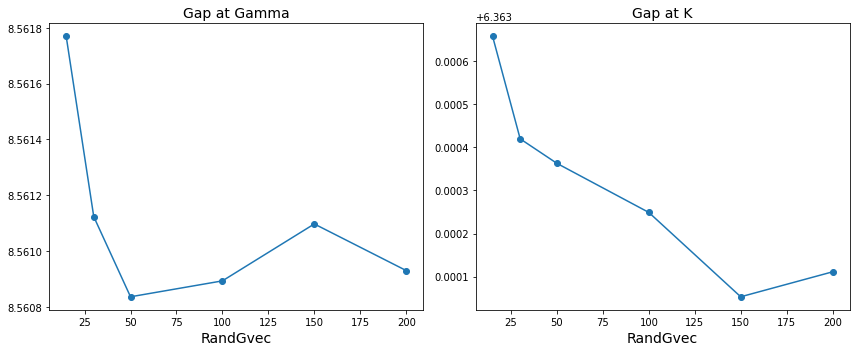

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandGvec,gap_G)
axes[0].scatter(RandGvec,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('RandGvec',size=14)

axes[1].plot(RandGvec, gap_K)
axes[1].scatter(RandGvec,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('RandGvec',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [17]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

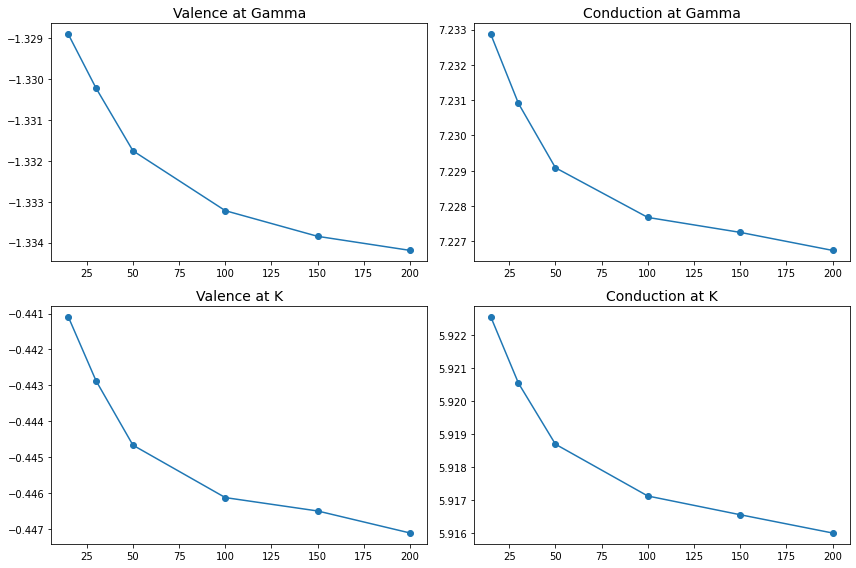

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandGvec,val_G)
axes[0,0].scatter(RandGvec,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandGvec, cond_G)
axes[0,1].scatter(RandGvec,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandGvec,val_K)
axes[1,0].scatter(RandGvec,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandGvec, cond_K)
axes[1,1].scatter(RandGvec,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

The states converge much slower than the associated gaps.

We perform a convergence run on the RandQpts parameter

In [19]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = [1000000,2000000,3000000,5000000,8000000] # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first RandGvec G-components of the coulomb potential 

inp.set_array_variables(units='RL',RandGvec=RandGvec)

# append runs for the Gamma point
for randqpts in RandQpts:
    idd = 'hf-G-randqpts_%s-randgvec_%s'%(randqpts,RandGvec)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(RandQpts=randqpts)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randqpts in RandQpts:
    idd = 'hf-K-randqpts_%s-randgvec_%s'%(randqpts,RandGvec)
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(RandQpts=randqpts)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [24]:
#study.runs[0]

In [25]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-G-randqpts_1000000-randgvec_100
Skip the run of hf-G-randqpts_5000000-randgvec_100
Skip the run of hf-G-randqpts_2000000-randgvec_100
Skip the run of hf-G-randqpts_3000000-randgvec_100
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of hf-K-randqpts_1000000-randgvec_100
Skip the run of hf-G-randqpts_8000000-randgvec_100Skip the run of
 hf-K-randqpts_3000000-randgvec_100
Skip the run of hf-K-randqpts_2000000-randgvec_100
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-K-randqpts_8000000-randgvec_100
Skip the run of hf-K-randqpts_5000000-randgvec_100
Task [8, 9] ended 
 


We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [26]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.560893, 8.557779, 8.55579, 8.556474, 8.55668],
 [6.363249, 6.360576, 6.358876, 6.359473, 6.359667])

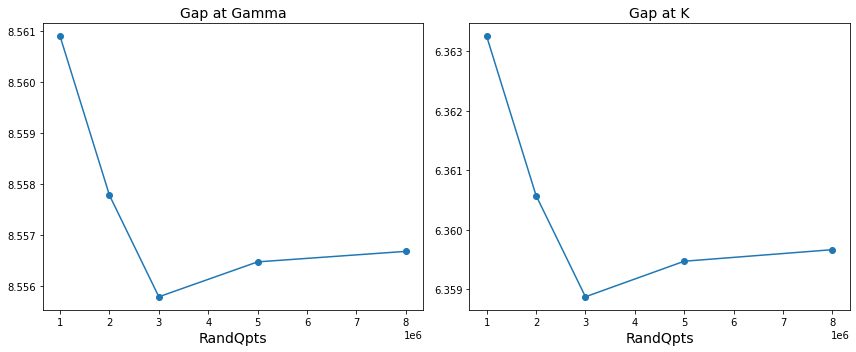

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandQpts,gap_G)
axes[0].scatter(RandQpts,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('RandQpts',size=14)
axes[1].plot(RandQpts, gap_K)
axes[1].scatter(RandQpts,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('RandQpts',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [28]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

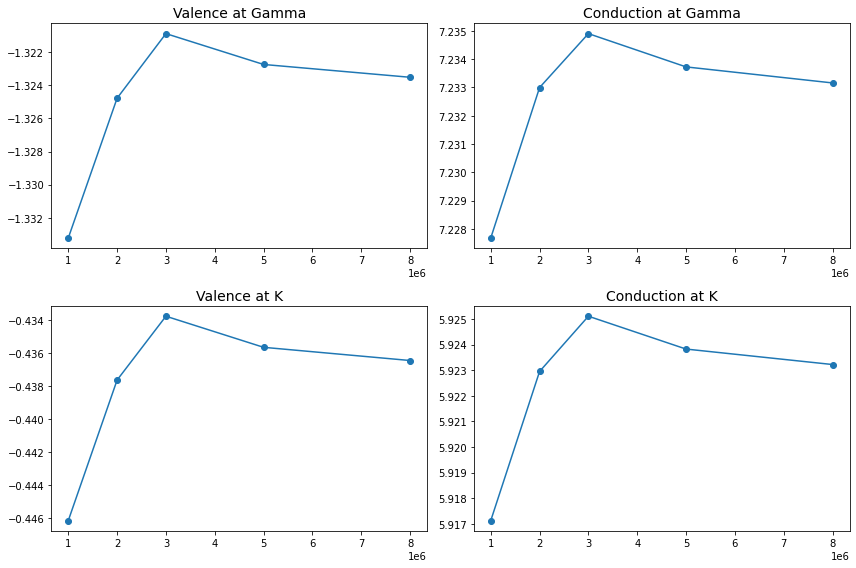

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandQpts,val_G)
axes[0,0].scatter(RandQpts,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandQpts, cond_G)
axes[0,1].scatter(RandQpts,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandQpts,val_K)
axes[1,0].scatter(RandQpts,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandQpts, cond_K)
axes[1,1].scatter(RandQpts,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

Also for the RandQpts parameter we observe that the gap is converged at the level of 1 meV at 5e6 while
the convergence of the individual states requires higher values. 

On the basis of this analysis we choose the converged parameters for the RIM and Coulomb cutoff as
* RandGVec = 100
* RandQPpts = 5000000

## HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 18x18x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

In [30]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

save_dir = Tools.make_p2y(source_dir)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We the define the input variables commmon to all the runs

In [32]:
start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37
RandGvec = 100
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'yambo -r -x -V all',
 'folder': 'GW_analysis/kpoints_18-nbnds_250',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [26.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [262858.0, 'Kb'],
  'FFTGvecs': [18201.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [100, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [116627.0, 'RL'],
  'VXCRLvcs': [116627.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 26, 27], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [33]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [36]:
#study.runs[0]

In [37]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-G-exxrlvcs_20.0Skip the run of
 Skip the run ofhf-G-exxrlvcs_40.0
 hf-G-exxrlvcs_10.0
Skip the run of hf-G-exxrlvcs_30.0
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of hf-K-exxrlvcs_10.0
Skip the run of hf-K-exxrlvcs_30.0
Skip the run of hf-K-exxrlvcs_40.0
Skip the run of hf-K-exxrlvcs_20.0
Task [4, 5, 6, 7] ended 
 


We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [38]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.524924, 8.554708, 8.556479, 8.556474],
 [6.418059, 6.361591, 6.359521, 6.359473])

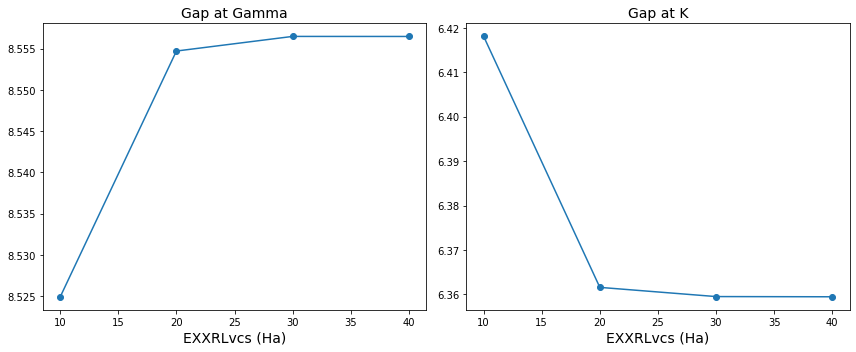

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 30 Ha

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [43]:
RandQpts = 5000000
RandGvec = 100 

start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1}
K_index = {18:37,30:91,42:169}

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

In [41]:
kpoints = [18,30,42]

In [48]:
study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_250.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_250'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 1 nodes on ismhpc (with 16 mpi and 2 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 4 parallel tasks
SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_30-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_30-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_42-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_42-nbnds_250. No operations performed.


In [49]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_analysis/kpoints_18-nbnds_250',
 'num_tasks': 4,
 'verbose': True,
 'input': {'args': 'yambo -r -x -V all',
  'folder': 'GW_analysis/kpoints_18-nbnds_250',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'HF_and_locXC'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [26.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [262858.0, 'Kb'],
   'FFTGvecs': [18201.0, 'RL'],
   'SE_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [100, 'RL'],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [30.0, 'Ha'],
   'VXCRLvcs': [30.0, 'Ha'],
   'DBsIOoff': 'none',
   'DBsFRAGpm': 'none',
   'PAR_def_mode': 'balanced',
   'CUTGeo': 'slab z',
   'Em1Anys': [[0.0, 0.0, 0.0], ''],
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'QPkrange': [[1, 1, 26, 27], ''],
   'QPerange': [[1, 37, 0.0, 

In [50]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1, 2, 3], [4, 5]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-K-kpoints_18
Skip the run of hf-G-kpoints_18
Skip the run of hf-G-kpoints_30
Skip the run of hf-K-kpoints_30
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5] 
Skip the run of Skip the run ofhf-K-kpoints_42 
hf-G-kpoints_42
Task [4, 5] ended 
 


In [51]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([8.556479, 8.5675, 8.571138000000001],
 [6.359521, 6.3721820000000005, 6.377230999999999])

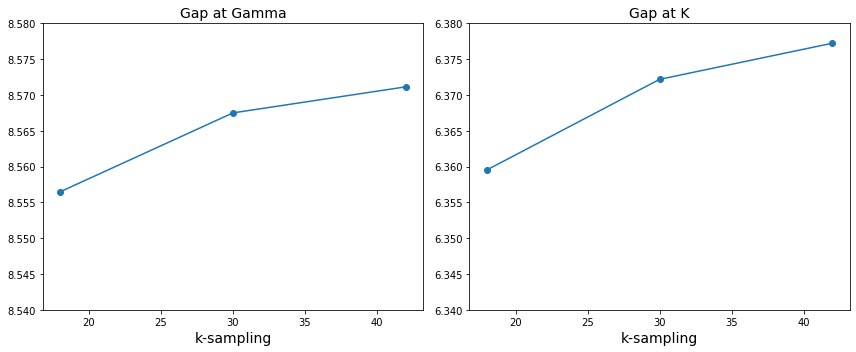

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[0].set_ylim(8.54,8.58)
axes[1].set_ylim(6.34,6.38)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

With the 42x42x1 sampling the HF gap both at $\Gamma$ and at $K$ is converged at
the level of 5 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

The aim of this analysis is to find a converged expression for the screening (that will be used also in the BSE calculations)
and to test the RIM_W.

### Convergence analysis of the screening

We use the 18x18x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters
needed to compute the screening function.

We perform this analysis __without__ the RIM_W.

In [53]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

save_dir = Tools.make_p2y(source_dir)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We the define the input variables commmon to all the runs

In [36]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
Gamma_index, K_index = 1, 37
RandGvec = 100
Randqpts = 5e6

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)

inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 2


First we run over NGsBlkXp

In [37]:
NGsBlkXp = [2.0,4.0,6.0,8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,100] # Bands in the response function
GbndRnge = [1,100]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_gamma','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])])
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])])

Initialize a Dataset with 2 parallel tasks


In [38]:
#study.runs[3]

In [39]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_2.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_2.0-bndsrnxp_100-gbndrnge_100
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_4.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_4.0-bndsrnxp_100-gbndrnge_100
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_100-gbndrnge_100
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_100-gbndrnge_100
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_100-gbndrnge_100
Task [8, 9] ended 
 


In [40]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([4.299445, 4.345637, 4.362794, 4.369999, 4.376764],
 [3.11461, 3.122084, 3.139232, 3.141598, 3.144256])

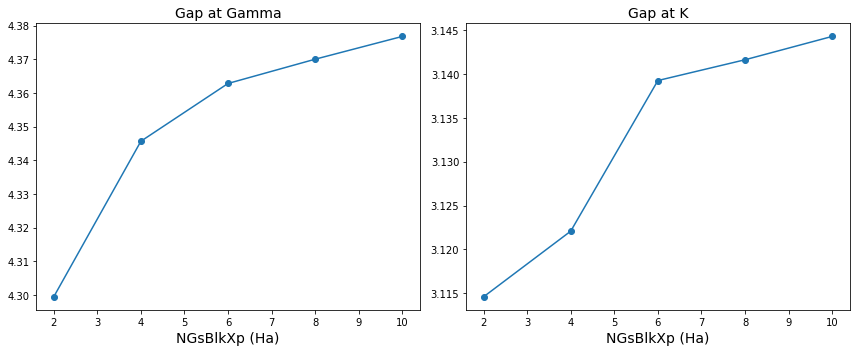

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We perform the convergence test on BndsRnXp using the value NGsBlkXp = 6 Ha, to have a 
balance between convergence and computational cost

In [60]:
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [[1,100],[1,200],[1,250]] # Bands in the response function
GbndRnge = [1,100]  # Bands in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bndsrnxp in BndsRnXp:
    inp.set_array_variables(BndsRnXp=bndsrnxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bndsrnxp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_gamma','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bndsrnxp[1])]) #,reformat=False
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bndsrnxp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bndsrnxp[1])]) #,reformat=False

Initialize a Dataset with 2 parallel tasks


In [61]:
#study.runs[2]

In [62]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_100-gbndrnge_100
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_200-gbndrnge_100
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_200-gbndrnge_100
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_100
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_100
Task [4, 5] ended 
 


In [67]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([4.362794, 4.368242, 4.3659550000000005],
 [3.139232, 3.1726170000000002, 3.178654])

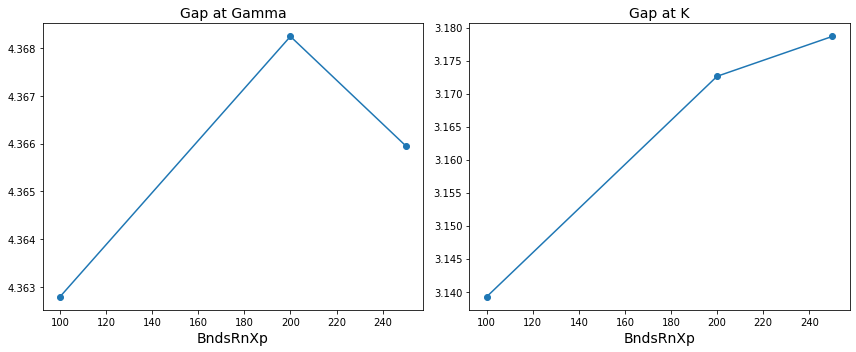

In [68]:
x_vals = [x[1] for x in BndsRnXp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('BndsRnXp',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('BndsRnXp',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We see that 250 band should ensure convergence in the range of about 5 meV.

Lastly we perform the convergence check on the number of bands used in the G expansion

In [75]:
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,250] # Bands in the response function
GbndRnge = [[1,100],[1,200],[1,250]]  # Bands in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for gbndrnge in GbndRnge:
    inp.set_array_variables(GbndRnge=gbndrnge)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_gamma','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])])
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])])

Initialize a Dataset with 2 parallel tasks


In [76]:
#study.runs[4]

In [77]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_100
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_100
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_200
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_200
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250
Task [4, 5] ended 
 


In [78]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([4.3659550000000005, 4.265421, 4.240527], [3.178654, 3.116367, 3.088822])

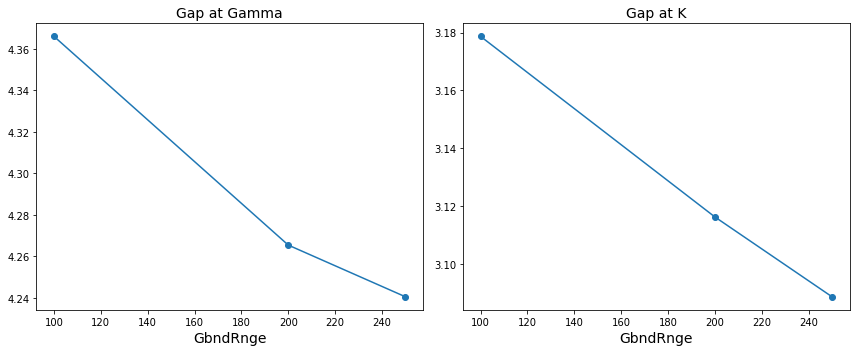

In [79]:
x_vals = [x[1] for x in GbndRnge]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('GbndRnge',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('GbndRnge',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

This analysis performed at the plasmon pole level reveals that : 
* NGsBlkXp equal to 6 Ha (but 8 could be a safer choice) ensure convergence at the level of 10 meV.
* BndsRnXp = 250 (bands in the response function) should ensure convergence in the range of about 5 meV.
* GbdnRnge = 250 is not fully satisfactory to ensure convergence on the Grenn function. Probably 
    400 bands could be needed.

### Analysis of RIM_W

We test the effects of the RIM_W and perform a convergence analysis on the number of G vectors in the RIM_W procedure

In [6]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
Gamma_index, K_index = 1, 37
RandGvec = 100
Randqpts = 5e6
EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,250]# Bands in the response function
GbndRnge = [1,250] # Bands in the Sigma_c

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 2


In [29]:
RandGvecW =[1,2,10,20]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for randgvecw in RandGvecW:
    inp.set_array_variables(units='RL',RandGvecW=randgvecw)
    # append run at G
    idd = 'pp-G-RIM_W-randgvecw_%s'%randgvecw
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_gamma','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250'],reformat=False)
    # append run at K
    idd = 'pp-K-RIM_W-randgvecw_%s'%randgvecw
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [30]:
#study.runs[3]

In [31]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
run command: mpirun -np 32 yambo -F pp-G-RIM_W-randgvecw_1.in -J "pp-G-RIM_W-randgvecw_1,ndb_rim_cutoff,ndb_hf_gamma,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_dipoles-bnds_250" -C pp-G-RIM_W-randgvecw_1
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_pp-G-RIM_W-randgvecw_1.sh
run command: mpirun -np 32 yambo -F pp-K-RIM_W-randgvecw_1.in -J "pp-K-RIM_W-randgvecw_1,ndb_rim_cutoff,ndb_hf_K,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_dipoles-bnds_250" -C pp-K-RIM_W-randgvecw_1
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_pp-K-RIM_W-randgvecw_1.sh
computation pp-G-RIM_W-randgvecw_1 is running...
computation pp-K-RIM_W-randgvecw_1 is running...
computation pp-G-RIM_W-randgvecw_1 ended
Run performed in 04m-17s
computation pp-K-RIM_W-randgvecw_1 ended
Run performed in 04m-19s
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-RI

In [32]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([3.943691, 3.8756, 3.874313, 3.874352],
 [2.791761, 2.719259, 2.7199869999999997, 2.719754])

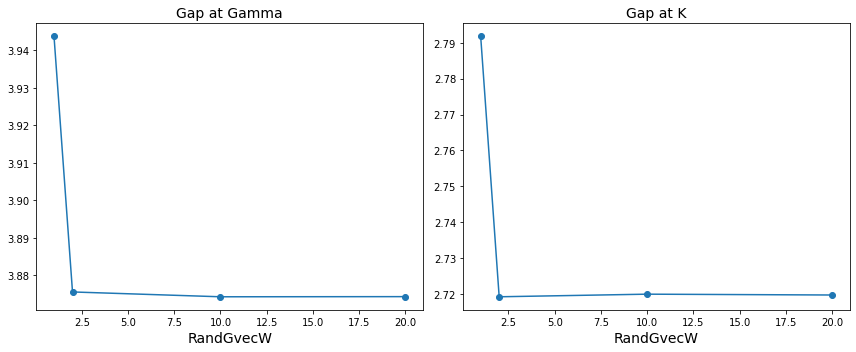

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandGvecW,gap_G)
axes[0].scatter(RandGvecW,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('RandGvecW',size=14)
axes[1].plot(RandGvecW, gap_K)
axes[1].scatter(RandGvecW,gap_K)
axes[1].set_xlabel('RandGvecW',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we set 
* RandGvecW = 10
as the converged value for this parameter.

### PP Analysis in function of the k-points sampling

We test the convergence of the PP gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

We compare the results achieved with and without the usage of the RIM_W integration.

In [4]:
kpoints = [18,30,42]

In [5]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
Gamma_index = {18:1,30:1,42:1}
K_index = {18:37,30:91,42:169}
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,250]# Bands in the response function
GbndRnge = [1,250] # Bands in the Sigma_c

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_250.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_250'%k
    Tools.build_SAVE(source_dir,run_dir)

    inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    
    # append run at G
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    inp.deactivate_RIM_W()
    idd = 'pp-G-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_gamma',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)
    inp.activate_RIM_W()
    idd = 'pp-G-kpoints_%s-RIM_W'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_gamma',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)
    
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    inp.deactivate_RIM_W()
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_K',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)
    inp.activate_RIM_W()
    idd = 'pp-K-kpoints_%s-RIM_W'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_K',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_250']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)

16 2
Initialize a Dataset with 2 parallel tasks
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.
SAVE folder already present in GW_analysis/kpoints_30-nbnds_250. No operations performed.
SAVE folder already present in GW_analysis/kpoints_42-nbnds_250. No operations performed.


In [6]:
study.ids

['pp-G-kpoints_18',
 'pp-G-kpoints_18-RIM_W',
 'pp-K-kpoints_18',
 'pp-K-kpoints_18-RIM_W',
 'pp-G-kpoints_30',
 'pp-G-kpoints_30-RIM_W',
 'pp-K-kpoints_30',
 'pp-K-kpoints_30-RIM_W',
 'pp-G-kpoints_42',
 'pp-G-kpoints_42-RIM_W',
 'pp-K-kpoints_42',
 'pp-K-kpoints_42-RIM_W']

In [7]:
#study.runs[2]

In [8]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]] 

Run the task [0, 1] 
Skip the run of pp-G-kpoints_18Skip the run of
 pp-G-kpoints_18-RIM_W
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-K-kpoints_18Skip the run of
 pp-K-kpoints_18-RIM_W
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-kpoints_30Skip the run of
 pp-G-kpoints_30-RIM_W
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-K-kpoints_30Skip the run of
 pp-K-kpoints_30-RIM_W
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-kpoints_42Skip the run of
 pp-G-kpoints_42-RIM_W
Task [8, 9] ended 
 
Run the task [10, 11] 
Skip the run of pp-K-kpoints_42
Skip the run of pp-K-kpoints_42-RIM_W
Task [10, 11] ended 
 


In [9]:
results_G = [results[r] for r in [0,4,8]]
results_G_rimw = [results[r] for r in [1,5,9]]
results_K = [results[r] for r in [2,6,10]]
results_K_rimw = [results[r] for r in [3,7,11]]

In [11]:
gap_G, gap_G_rimw = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_G_rimw.append(results_G_rimw[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))

gap_K, gap_K_rimw = [],[]
for ind,k in enumerate(kpoints):
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
    gap_K_rimw.append(results_K_rimw[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_K, gap_K_rimw

([3.088822, 2.894613, 2.822524], [2.7199869999999997, 2.713771, 2.713503])

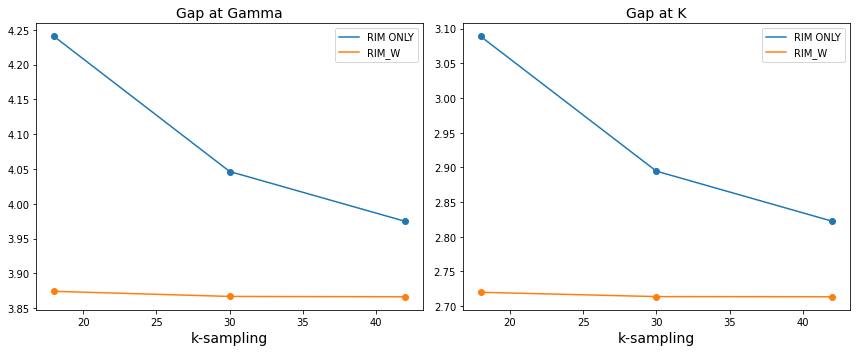

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints, gap_G,label='RIM ONLY')
axes[0].scatter(kpoints,gap_G)
axes[0].plot(kpoints, gap_G_rimw,label='RIM_W')
axes[0].scatter(kpoints,gap_G_rimw)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K,label='RIM ONLY')
axes[1].scatter(kpoints,gap_K)
axes[1].plot(kpoints, gap_K_rimw,label='RIM_W')
axes[1].scatter(kpoints,gap_K_rimw)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

On the basis of this analysis we see that the usage of the RIM_W interpolation ensures a faster convergence
of the plasmon-pole correction in function of the $k$-points sampling.

## Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

At this level of the analysis we perform these computations for 18x18x1 and 30x30x1 $k$-points samplings.

In [87]:
kpoints = 30 # 18 30
run_dir = 'GW_analysis/kpoints_%s-nbnds_250'%kpoints

In [58]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 23,30
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,250]# Bands in the response function
GbndRnge = [1,250] # Bands in the Sigma_c

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 1


In [59]:
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
jobname = [idd,'ndb_rim_cutoff','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),
           'ndb_dipoles-bnds_250','ndb_hf_allBZ']
results = code.run(input=inp,run_dir=run_dir,name=idd,jobname=jobname,reformat=False)

Skip the run of pp-allBZ-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250


### Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [88]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [89]:
ndbQP = 'pp-allBZ-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250/ndb.QP'

In [90]:
# with BANDS_kpts

band_range = [start_band,stop_band]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp['variables']['BANDS_bands'] = [band_range,'']
inp['variables']['BANDS_steps'] = [bands_step,'']
inp['variables']['BANDS_kpts'] = [path,'']
inp['variables']['cooIn'] = 'rlu'
inp['variables']['cooOut'] = 'rlu'

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20,'']
study.append_run(id=idd,input=inp,runner=ypp_code) 

idd = 'ypp_bands_gw_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=ypp_code)

Initialize a Dataset with 2 parallel tasks


In [91]:
#study.runs[1]

In [92]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
run command: mpirun -np 16 ypp -F ypp_bands_gw_boltz.in -J ypp_bands_gw_boltz -C ypp_bands_gw_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_gw_boltz.sh
computation ypp_bands_gw_boltz is running...
run command: mpirun -np 16 ypp -F ypp_bands_dft_boltz.in -J ypp_bands_dft_boltz -C ypp_bands_dft_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_dft_boltz.sh
computation ypp_bands_dft_boltz is running...
computation ypp_bands_dft_boltz ended
Run performed in 10s
computation ypp_bands_gw_boltz ended
Run performed in 11s
Task [0, 1] ended 
 


In [93]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ GW bands')

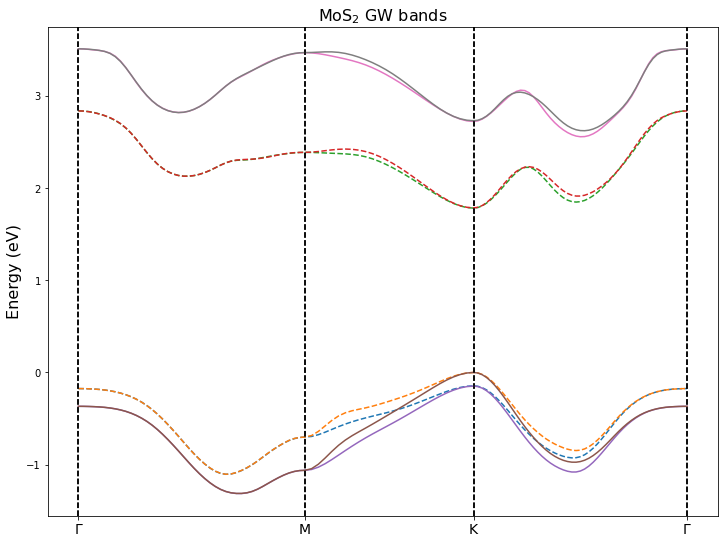

In [86]:
# Results for the 18x18x1 kpoints sampling 

fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-',label='gw')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW bands',size=16)

Text(0.5, 1.0, 'MoS$_2$ GW bands')

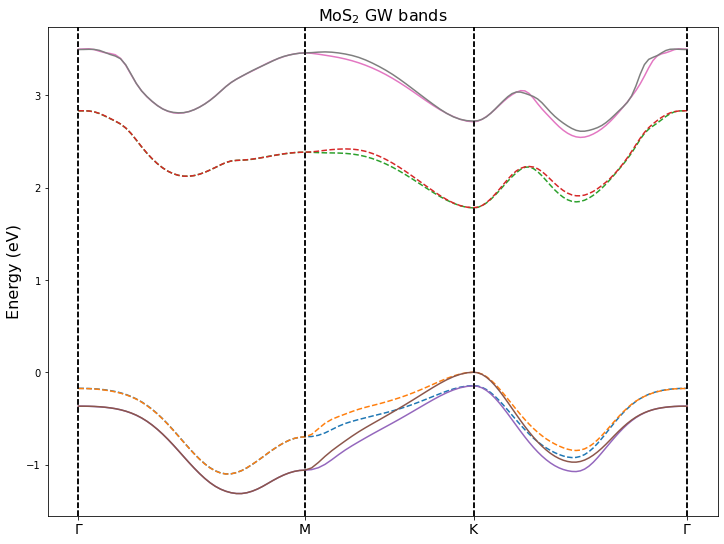

In [94]:
# Results for the 30x30x1 kpoints sampling 

fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-',label='gw')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW bands',size=16)